In [1]:
%load_ext autoreload
%autoreload 2
import pylab as plt
import torch
import numpy as np
from tqdm.auto import tqdm

## Nested sampling 

In [2]:
def get_directions(B, D):
    """This function generates a minibatch of D-dimensional random directions."""
    t = torch.randn(B, D)
    l = (t**2).sum(axis=-1)**0.5
    n = t/l.unsqueeze(-1)
    return n

In [3]:
def get_slice_sample_points(B, S):
    """This function generates a minibatch of S slice sample positions."""
    hard_bounds = torch.tensor([-1., 1.]).unsqueeze(0).repeat((B,1))
    current_bounds = hard_bounds.clone()
    L = torch.empty((B, S))
    for i in range(S):
        x = torch.rand(B)*(current_bounds[:,1]-current_bounds[:,0])+current_bounds[:,0]
        L[:,i] = x
        current_bounds[x<0,0] = x[x<0]
        current_bounds[x>0,1] = x[x>0]
    return L

In [4]:
def gen_new_samples(X_seeds, logl_fn, logl_th, num_steps = 10, max_step_size = 1., samples_per_slice = 20):
    """This function generates new samples within the likelihodo constraint logl_fn > log_th."""
    B, D = X_seeds.shape
    C = torch.zeros(B)  # counter for accepted points
    X = X_seeds.clone()
    logl = torch.ones(B)*(-np.inf)
    for i in range(num_steps):
        N = get_directions(B, D)
        L = get_slice_sample_points(B, S = samples_per_slice)*max_step_size
        dX = N.unsqueeze(-2)*L.unsqueeze(-1)
        pX = X.unsqueeze(-2) + dX # proposals
        logl_prop = logl_fn(pX)
        accept_matrix = logl_prop > logl_th
        idx = torch.argmax(accept_matrix.int(), dim=1)
        nX = torch.stack([pX[i][idx[i]] for i in range(B)], dim=0)
        logl_selected = torch.stack([logl_prop[i][idx[i]] for i in range(B)], dim=0)
        accept_any = (accept_matrix.sum(dim=-1)>0)
        X[accept_any] = nX[accept_any]
        logl[accept_any] = logl_selected[accept_any]
        C[accept_any] += 1
    return X[C==num_steps], logl[C==num_steps]

In [5]:
def nested_sampling(X_init, logl_fn, logl_th_max = np.inf, max_steps = 100000, num_batch_samples = 100, epsilon = 1e-6):
    """Run nested sampling, staring with X_init live points."""
    NLP, D = X_init.shape
    X_live = X_init.clone()
    L_live = logl_fn(X_live)
    B = min(num_batch_samples, NLP)  # Number of samples generated simultanously
    V = 1.  # initial volume is set to 1.
    samples_X = []
    samples_logl = []  # logl values
    samples_logv = []  # estimate of constrained volume
    samples_Z = []
    samples_logwt = []
    logl_th = -np.inf
    Z = 0
    Z_rest = np.inf
    
    pbar = tqdm(range(max_steps))
    for i in pbar:
#        pbar.set_description("logl_min=%.2f, Z=%.2e"%(logl_th, Z))
        pbar.set_description("Z_sum=%.2e, Z_rest=%.2e, logl_min=%.2f"%(Z, Z_rest, logl_th))
        idx_batch = np.random.choice(range(NLP), B, replace = True)
        X_batch = X_live[idx_batch]
        logl_th = L_live.min()
        if logl_th > logl_th_max:  # Stop sampling once maxmimum threshold is reached
            break
        X_new, L_new = gen_new_samples(X_batch, logl, logl_th, num_steps = 10)
        for i in range(len(X_new)):
            if L_new[i] > L_live.min():
                idx_min = np.argmin(L_live)
                Lmin = L_live[idx_min].item()*1.
                samples_X.append(1.*X_live[idx_min].numpy())
                samples_logl.append(Lmin)
                samples_logv.append(np.log(V))
                L_live[idx_min] = L_new[i]*1.0
                X_live[idx_min] = X_new[i]*1.0
                V *= (1-1/NLP)  # Volume estimate per sample
                dZ = V/NLP*np.exp(Lmin)
                samples_Z.append(dZ)
                samples_logwt.append(Lmin + np.log(V/NLP))
                Z = Z + dZ
                Z_rest = V*torch.exp(L_live.max()*1.)
                #print(L_live.max()*1.)
            else:
                break
        if Z_rest < Z*epsilon:
#            print(Z_rest, Z)
            break
    samples_logv = np.array(samples_logv)
    samples_logl = np.array(samples_logl)
    samples_X = np.array(samples_X)
    samples_logwt = np.array(samples_logwt)
    return samples_X, samples_logv, samples_logl, samples_logwt, X_live, L_live

In [6]:
def grow_live_points(X_init, logl_fn, logl_th_max = -1.0, num_batch_samples = 100, num_samples = 10000):
    NLP, D = X_init.shape
    X_live = X_init.clone()
    L_live = logl_fn(X_live)
    B = min(num_batch_samples, NLP)  # Number of samples generated simultanously
    while len(X_live) < num_samples:
        NLP = len(X_live)
        idx_batch = np.random.choice(range(NLP), B, replace = True)
        X_batch = X_live[idx_batch]
        X_new, L_new = gen_new_samples(X_batch, logl, logl_th_max, num_steps = 10)
        X_live = torch.cat([X_live, X_new])
        L_live = torch.cat([L_live, L_new])
    return X_live, L_live

In [10]:
def get_threshold(samples_logl, samples_logwt, p = 1e-6):
#    logwt = samples_logl[1:]+np.log(samples_logv[:-1]-samples_logv[1:])
    wt = np.exp(samples_logwt)
    wt /= wt.sum()
    cwt = np.cumsum(wt)
    return np.interp(p, cwt, samples_logl)

## Tests

### Plotting live points

In [29]:
def logl(u):
    ret = -(0.5*(u[..., :]**2)/0.1**2).sum(axis=-1)**1.0
    return ret
X_init = torch.randn(100, 15)
samples_X, samples_logv, samples_logl, samples_logwt, X_live, L_live = nested_sampling(X_init, logl, logl_th_max = -.0, num_batch_samples = 50, epsilon = 1e-6)
#plt.scatter(X_live[:,0], X_live[:,1], marker='.', c = L_live)
#plt.colorbar()

  0%|          | 0/100000 [00:00<?, ?it/s]

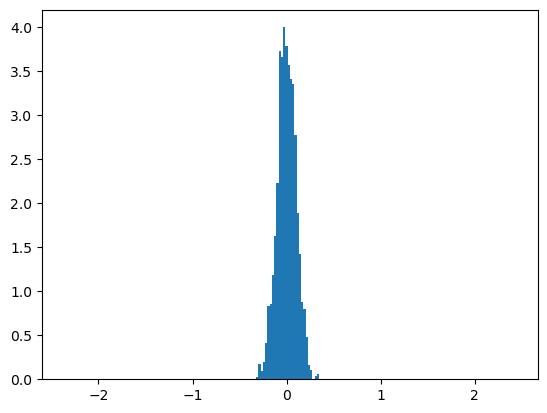

In [30]:
plt.hist(samples_X[:,0], weights = np.exp(samples_logwt-samples_logwt.max()), bins = 200, density = True);

In [34]:
th = get_threshold(samples_logl, samples_logwt, p = 1e-3)
print(np.exp(th), th)

6.40943262103206e-09 -18.86549508459107


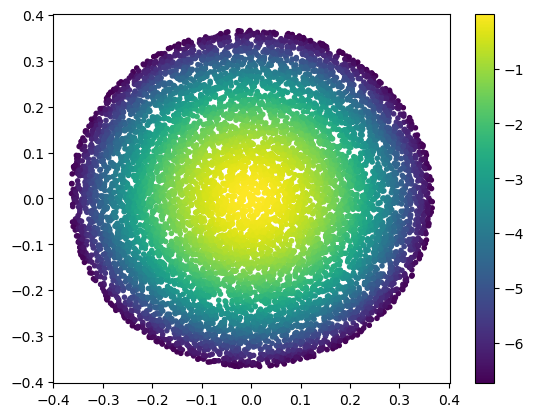

In [28]:
X, L = grow_live_points(X_live, logl, num_samples = 10000, logl_th_max = th)
plt.scatter(X[:,0], X[:,1], marker='.', c = L)
plt.colorbar()